In [11]:
!pip install fastbook torch torchvision mlflow

Defaulting to user installation because normal site-packages is not writeable


In [67]:
from fastbook import *
import os.path

In [117]:
source_folder = '/content/avatars'  # Путь к папке с исходными данными
train_folder = '/content/train'    # Путь к папке для тренировочных данных
test_folder = '/content/test'       # Путь к папке для тестовых данных

In [118]:
#!mkdir -p {source_folder}
#archive_tgz = "/content/avatars/avatars.tar.gz"
#if (os.path.isfile(archive_tgz) == False):
#    download_url('http://radio.123automate.it:8080/tmp/avatars.tar.gz', archive_tgz)

In [119]:
#!tar zxf {archive_tgz} -C /content/avatars/

In [120]:
from random import sample

def split_data(source_folder, train_folder, test_folder, test_size=0.2):
    
    # Обходим папки в исходной директории
    categories = ['good', 'bad']
    for category in categories:
        test_folder_category = os.path.join(test_folder, category)
        train_folder_category = os.path.join(train_folder, category)

        # Создаем целевые папки, если они еще не существуют
        os.makedirs(test_folder_category, exist_ok=True)
        os.makedirs(train_folder_category, exist_ok=True)

        category_path = os.path.join(source_folder, category)
        files = os.listdir(category_path)
        
        # Выбираем случайные файлы для тестового набора
        test_files = sample(files, int(len(files) * test_size))
        
        # Остальные файлы пойдут в тренировочный набор
        train_files = [f for f in files if f not in test_files]
        
        # Перемещаем файлы в соответствующие папки
        for file in test_files:
            shutil.copy(os.path.join(category_path, file), os.path.join(test_folder_category, file))
        for file in train_files:
            shutil.copy(os.path.join(category_path, file), os.path.join(train_folder_category, file))

In [138]:
!rm -rf /content/train
!rm -rf /content/test
split_data(source_folder, train_folder, test_folder, test_size=0.3)

In [139]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import os
import numpy as np
from PIL import Image

In [140]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [141]:
train_data = datasets.ImageFolder(train_folder, transform=train_transforms)
test_data = datasets.ImageFolder(test_folder, transform=test_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)


['good', 'good', 'bad', 'bad', 'good', 'good', 'good', 'good', 'bad', 'good', 'bad', 'bad', 'bad', 'good', 'good', 'bad', 'good', 'good', 'good', 'good', 'good', 'bad', 'good', 'bad', 'good', 'bad', 'good', 'bad', 'bad', 'good', 'good', 'good']


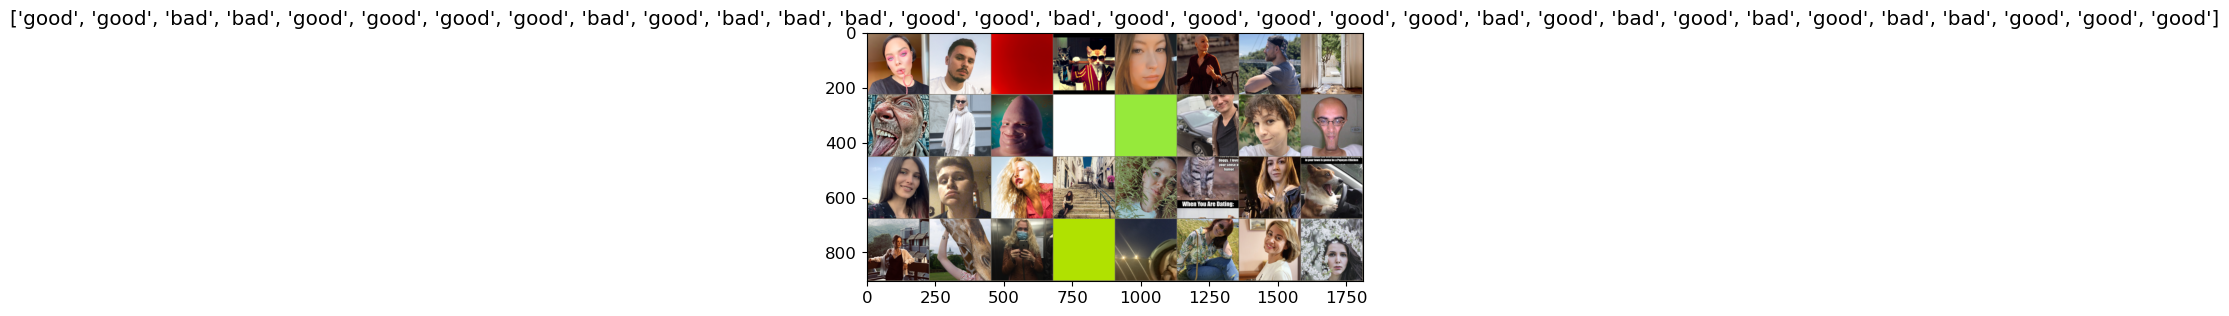

In [142]:
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Получить пакет обучающих данных
inputs, classes = next(iter(test_loader))

# Сделать сетку из пакета
out = torchvision.utils.make_grid(inputs)
print([train_data.classes[x] for x in classes])
imshow(out, title=[train_data.classes[x] for x in classes])


In [143]:
%env MLFLOW_TRACKING_URI=sqlite:////home/sir/realy/!avatars/mlruns.db

env: MLFLOW_TRACKING_URI=sqlite:////home/sir/realy/!avatars/mlruns.db


In [144]:
import mlflow
mlflow.set_tracking_uri(os.environ['MLFLOW_TRACKING_URI'])
mlflow.set_experiment("realy-avatars")
mlflow.pytorch.autolog()

In [145]:
import torch
import torch.nn as nn
from torchvision import models

# Загрузка предобученной модели ResNet
model = models.resnet18(pretrained=True)

# Замена последнего слоя для соответствия количеству классов (2 в вашем случае)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 класса

# Перенос модели на GPU, если доступно
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [146]:
import torch.optim as optim

# Кросс-энтропийная потеря
criterion = nn.CrossEntropyLoss()

# Оптимизатор (например, Adam)
optimizer = optim.Adam(model.parameters(), lr=0.00001) #  lr=0.0001

In [147]:
optimizer.defaults['lr']

1e-05

In [149]:
num_epochs = 15  # Количество эпох обучения
with mlflow.start_run():
    mlflow.log_param('lr', optimizer.defaults['lr'])
    mlflow.log_param('num_epochs', num_epochs)
    for epoch in range(num_epochs):
        model.train()  # Переключение в режим обучения

        running_loss = 0.0
        for inputs, labels in train_loader:
            # перенос данных на устройство
            inputs, labels = inputs.to(device), labels.to(device)

            # Обнуление градиентов оптимизатора перед каждым батчем
            optimizer.zero_grad()

            # Прямое распространение, обратное распространение и оптимизация
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # Оценка потерь на тестовом наборе
        model.eval()  # Переключение в режим оценки
        test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)

        test_loss /= len(test_loader.dataset)
        mlflow.log_metric("train_loss", epoch_loss)
        mlflow.log_metric("test_loss", test_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}')
        if (test_loss < 0.2 and optimizer.defaults['lr']>0.000005):
            optimizer = optim.Adam(model.parameters(), lr=0.000005) #  lr=0.0001
            print("Learning rate decreased")

        if (test_loss < 0.1 and optimizer.defaults['lr']>0.000001):
            optimizer = optim.Adam(model.parameters(), lr=0.000001) #  lr=0.0001
            print("Learning rate decreased")

        if (test_loss < 0.18 or (epoch_loss < test_loss and test_loss < 0.23) or (epoch_loss < 0.16)):
            print("Good enough, breaking here")
            break



Epoch 1/15, Train Loss: 0.2258, Test Loss: 0.2318
Epoch 2/15, Train Loss: 0.1903, Test Loss: 0.2366
Epoch 3/15, Train Loss: 0.1784, Test Loss: 0.2326
Epoch 4/15, Train Loss: 0.1862, Test Loss: 0.2262
Good enough, breaking here


In [150]:
model.eval()  # Переключение модели в режим оценки
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy on test set: {accuracy*100:.2f}%')


Accuracy on test set: 91.81%


In [152]:
import torch
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

model.eval()  # Переключение модели в режим оценки
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())  # Сохраняем предсказания
        all_labels.extend(labels.cpu().numpy())  # Сохраняем истинные метки

# Расчет метрик
accuracy = accuracy_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions, average='macro')
precision = precision_score(all_labels, all_predictions, average='macro')
f1 = f1_score(all_labels, all_predictions, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9181
Recall: 0.8818
Precision: 0.9172
F1 Score: 0.8970


In [153]:
!mkdir -p /content/models
!mkdir -p /content/result
model_path = f'/content/models/resnet_model{accuracy*100:.2f}.pth'  # Путь для сохранения модели
optimizer_path = f'/content/result/resnet_optimizer{accuracy*100:.2f}.pth'  # Путь для сохранения оптимизатора

In [154]:
# Сохранение модели
torch.save(model.state_dict(), model_path)

In [155]:
# остальные ячейки ниже не нужны, если мы не собираемся дообучать существующую модель

In [156]:
# Сохранение модели и состояния оптимизатора
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, optimizer_path)

In [ ]:
mlflow.log_artifact("model", )

In [53]:
# Загрузка модели и оптимизатора
model = models.resnet18(pretrained=False)  # Повторная инициализация модели
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # Адаптация последнего слоя под количество классов

optimizer = optim.Adam(model.parameters(), lr=0.001)  # Повторная инициализация оптимизатора

checkpoint = torch.load(optimizer_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model = model.to(device)  # Перенос модели на GPU, если это необходимо
model.eval()  # Переключение модели в режим оценки


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')


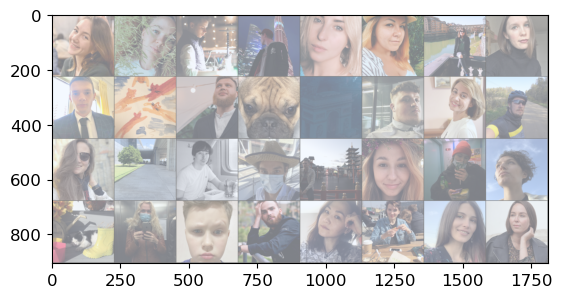

Actual labels:  1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1
Predicted    :  1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')


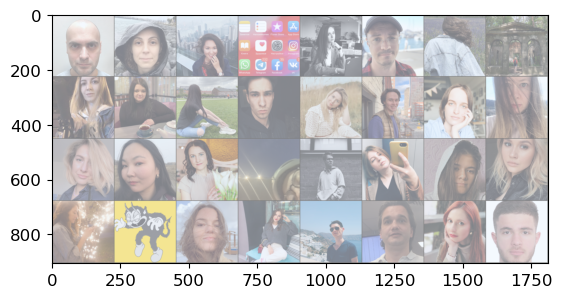

Actual labels:  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1
Predicted    :  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1
tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')


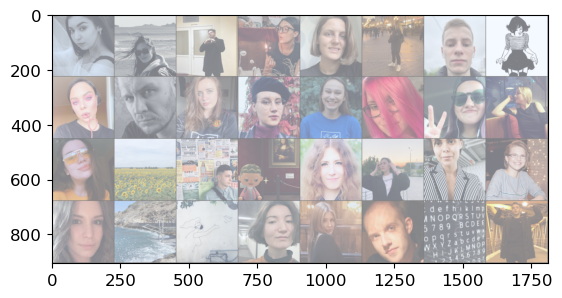

Actual labels:  1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1
Predicted    :  1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1
tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


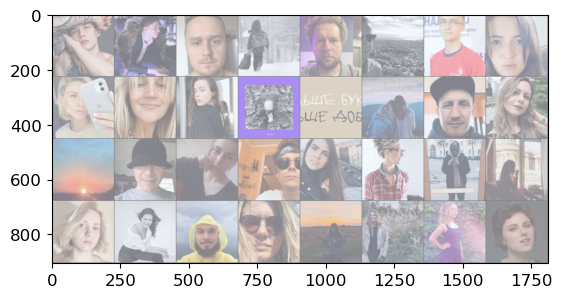

Actual labels:  1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
Predicted    :  1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1], device='cuda:0')


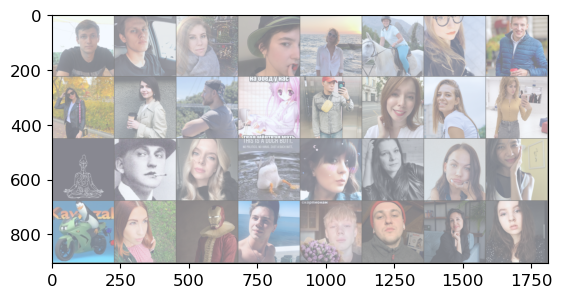

Actual labels:  1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 0 1 1 1
Predicted    :  1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 0 1 1 1
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')


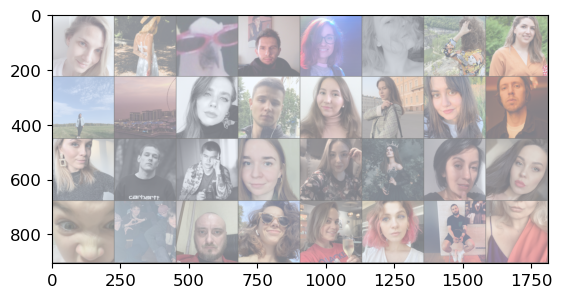

Actual labels:  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1
Predicted    :  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1
tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


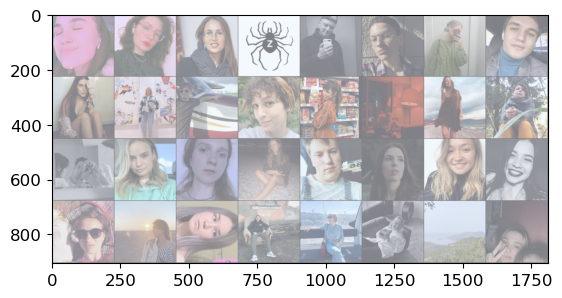

Actual labels:  1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
Predicted    :  1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1])
tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1], device='cuda:0')


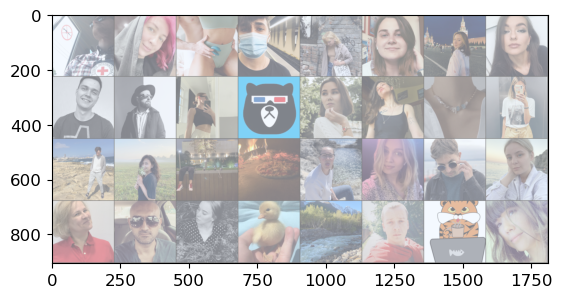

Actual labels:  1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1
Predicted    :  1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')


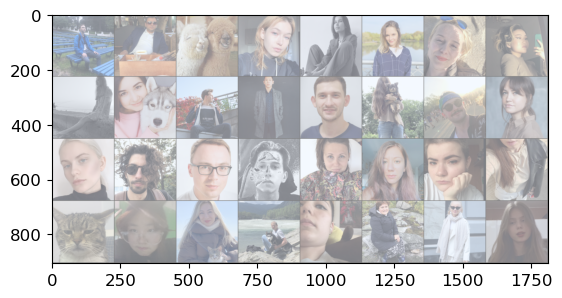

Actual labels:  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1
Predicted    :  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


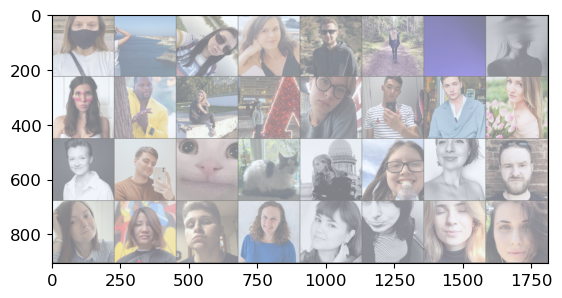

Actual labels:  1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted    :  1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


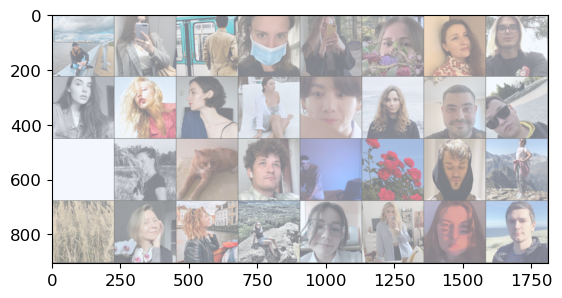

Actual labels:  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
Predicted    :  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0])
tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0], device='cuda:0')


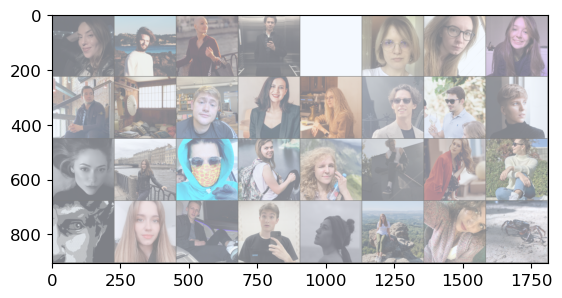

Actual labels:  1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0
Predicted    :  1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0], device='cuda:0')


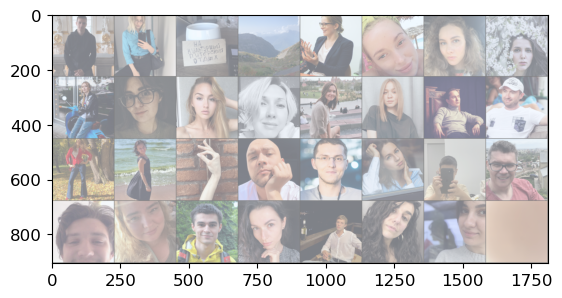

Actual labels:  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0
Predicted    :  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0
tensor([1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])
tensor([1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], device='cuda:0')


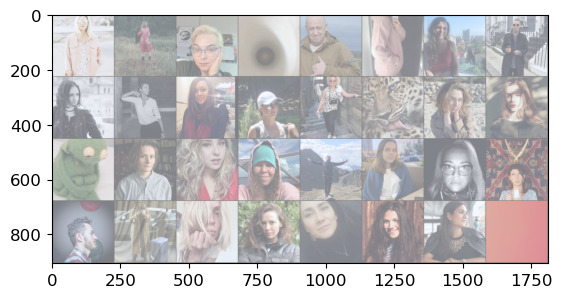

Actual labels:  1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
Predicted    :  1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


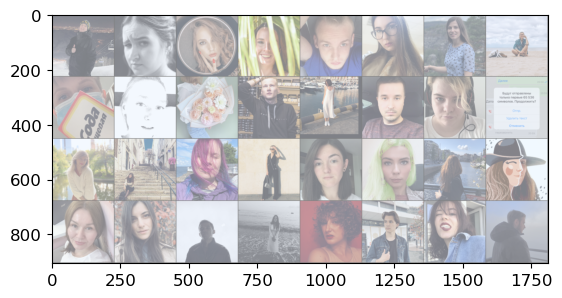

Actual labels:  1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
Predicted    :  1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
tensor([1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1])
tensor([1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1], device='cuda:0')


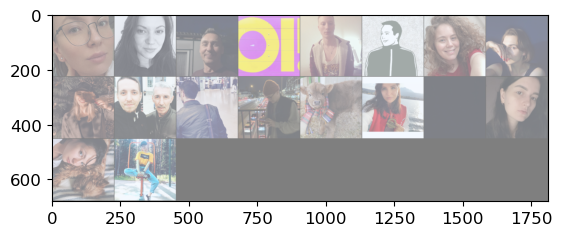

IndexError: index 18 is out of bounds for dimension 0 with size 18

In [54]:
import matplotlib.pyplot as plt

model.eval()  # Switch model to evaluation mode

def imshow(img):
    """Function to display an image"""
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        print(labels)
        inputs, labels = inputs.to(device), labels.to(device)
        print(labels)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Show images and labels
        imshow(torchvision.utils.make_grid(inputs.cpu().data[:32], normalize=True))
        print('Actual labels: ', ' '.join(f'{labels[j]}' for j in range(32)))
        print('Predicted    : ', ' '.join(f'{predicted[j]}' for j in range(32)))

accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy:.2f}%')
